In [1]:
import folium
from folium import plugins
import pandas as pd
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('all_data_Moscow_mean_T.csv')
df.head()

,Unnamed: 0,date,T
0,0,20151201,272.237556
1,1,20151202,270.353706
2,2,20151203,270.480820
3,3,20151204,272.624268
4,4,20151205,274.647697


Populating the interactive namespace from numpy and matplotlib


C:\Python\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


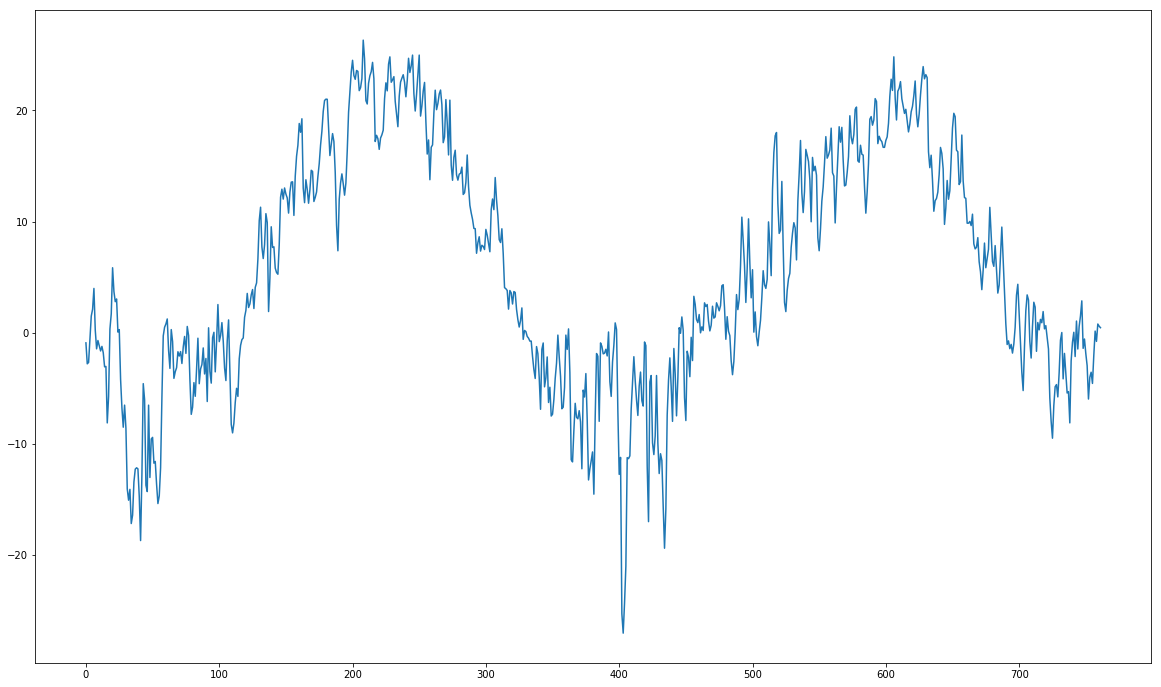

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

T = df['T'] - 273.15
plt.plot(T)

In [4]:
T_train = T[:600]
T_test = T[600:]

In [5]:
# def MSE(predict, etalon):
#     diff = np.array(predict - etalon)
#     return np.mean(diff**2)
from sklearn.metrics import mean_squared_error as MSE

### Завтра как вчера

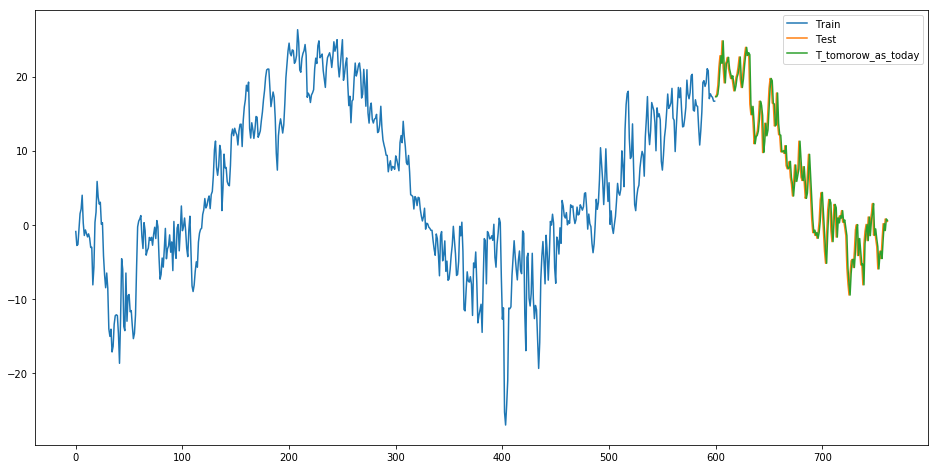

In [6]:
y_hat = T_test.copy()

T_tomorow_as_today = T_test[:-1]
T_tomorow_as_today = pd.concat([pd.Series([T_test[600]]), T_tomorow_as_today])

y_hat.values[:] = T_tomorow_as_today[:]
plt.figure(figsize=(16,8))
plt.plot(T_train, label='Train')
plt.plot(T_test, label='Test')
plt.plot(y_hat, label='T_tomorow_as_today')
plt.legend(loc='best')
plt.show()

In [9]:
MSE(T_tomorow_as_today, T_test)

4.332331305859502

### SARIMAX

In [67]:
# критерий Дики-Фуллера
test_ = sm.tsa.adfuller(T_train)
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -2.407765414929881
p-value:  0.13955666243588805
Critical values:  {'1%': -3.4413510722333087, '5%': -2.8663934413235266, '10%': -2.5693547658168003}
есть единичные корни, ряд не стационарен


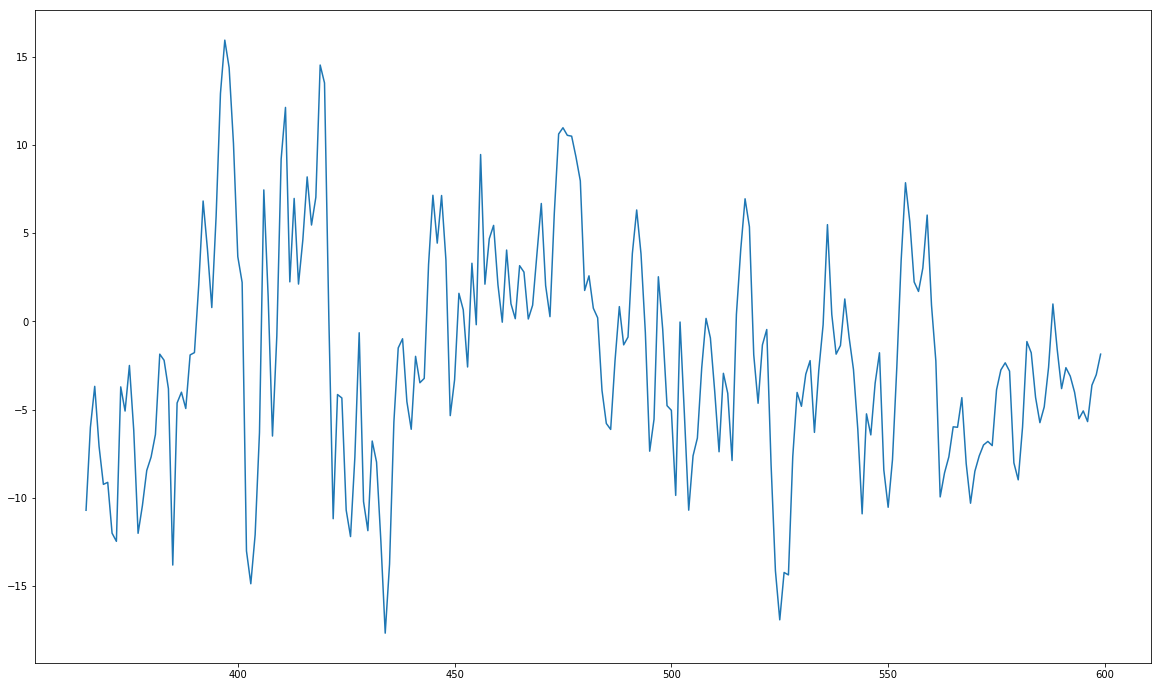

In [70]:
# интешрирование по ряду
train_diff = T_train.diff(periods=365).dropna()
plt.plot(train_diff)

In [71]:
test_ = sm.tsa.adfuller(train_diff)
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.913810668466791
p-value:  3.277875158991662e-05
Critical values:  {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}
единичных корней нет, ряд стационарен


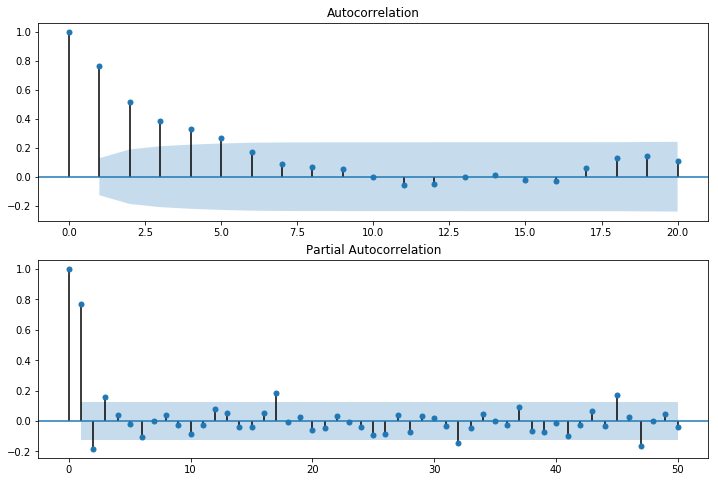

In [72]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=50, ax=ax2)

In [94]:
#ACF
q = 5
Q = 0

#PACF
p = 2
P = 0

d = 0
D = 1

s = 365

In [95]:
best_model=sm.tsa.statespace.SARIMAX(T_train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

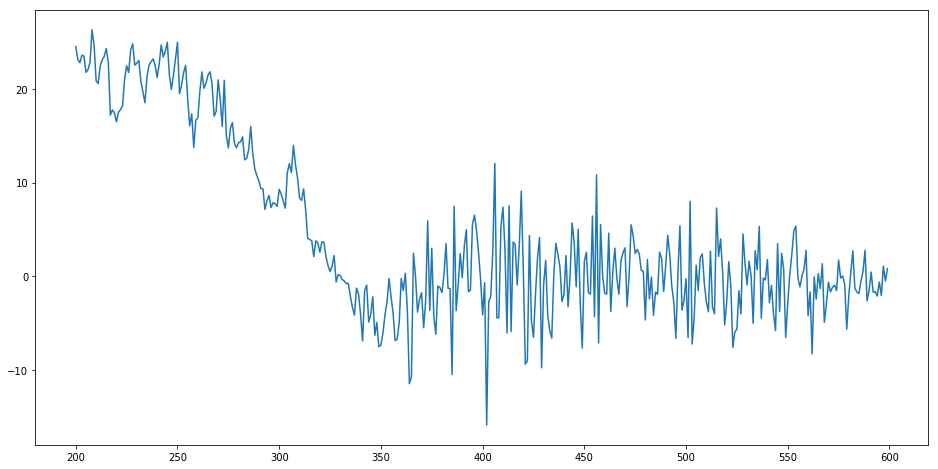

In [96]:
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[200:], label='Train')
plt.show()

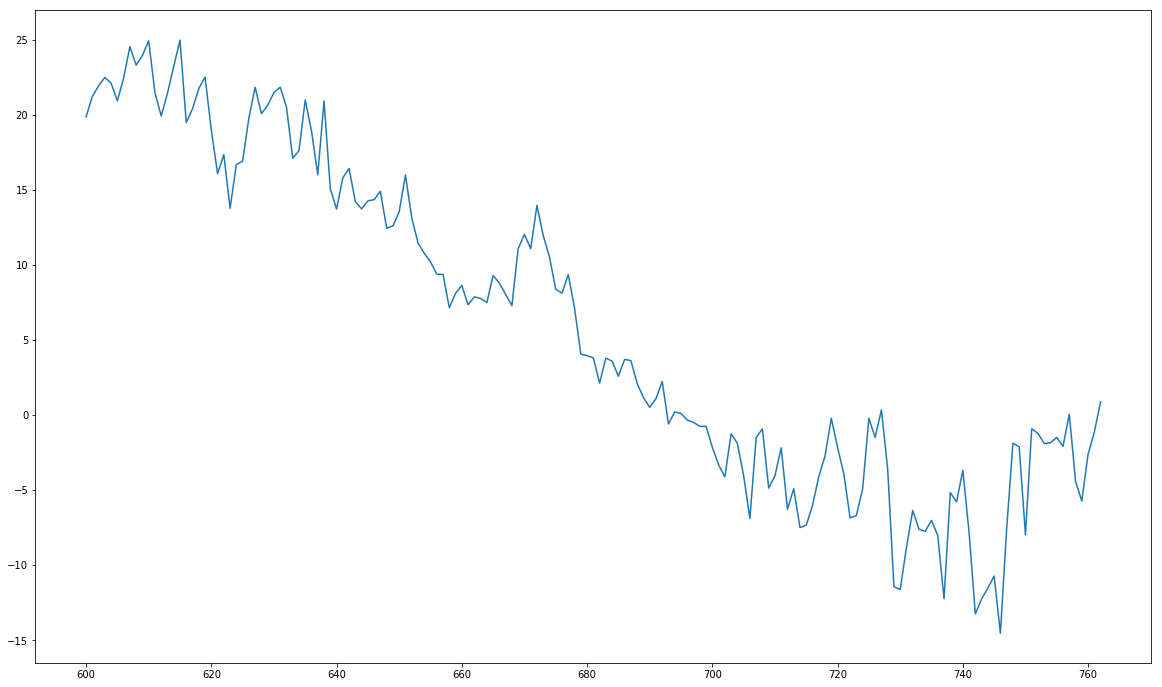

In [97]:
forecast = best_model.predict(start = 600, end = 762)
plt.plot(forecast)

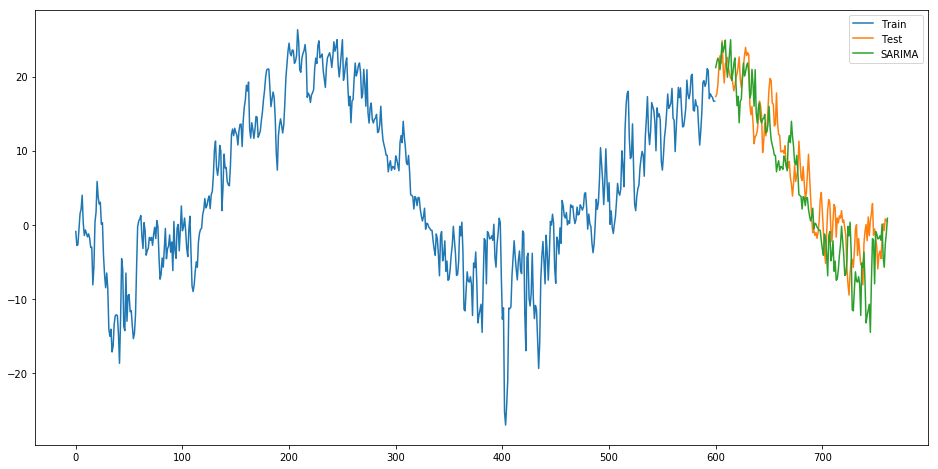

In [104]:
y_hat = T_test.copy()
y_hat.values[:] = forecast[1:]
plt.figure(figsize=(16,8))
plt.plot(T_train, label='Train')
plt.plot(T_test, label='Test')
plt.plot(y_hat, label='SARIMAX')
plt.legend(loc='best')
plt.show()

In [107]:
MSE(y_hat, T_test)

22.42834863021438